In [1]:
import pandas as pd
import missingno as msno

In [2]:
data = pd.read_csv('data/train_logs.csv')

In [3]:
data.head(5)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int64 
 2   down_time        int64 
 3   up_time          int64 
 4   action_time      int64 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int64 
 10  word_count       int64 
dtypes: int64(6), object(5)
memory usage: 705.5+ MB


<AxesSubplot:>

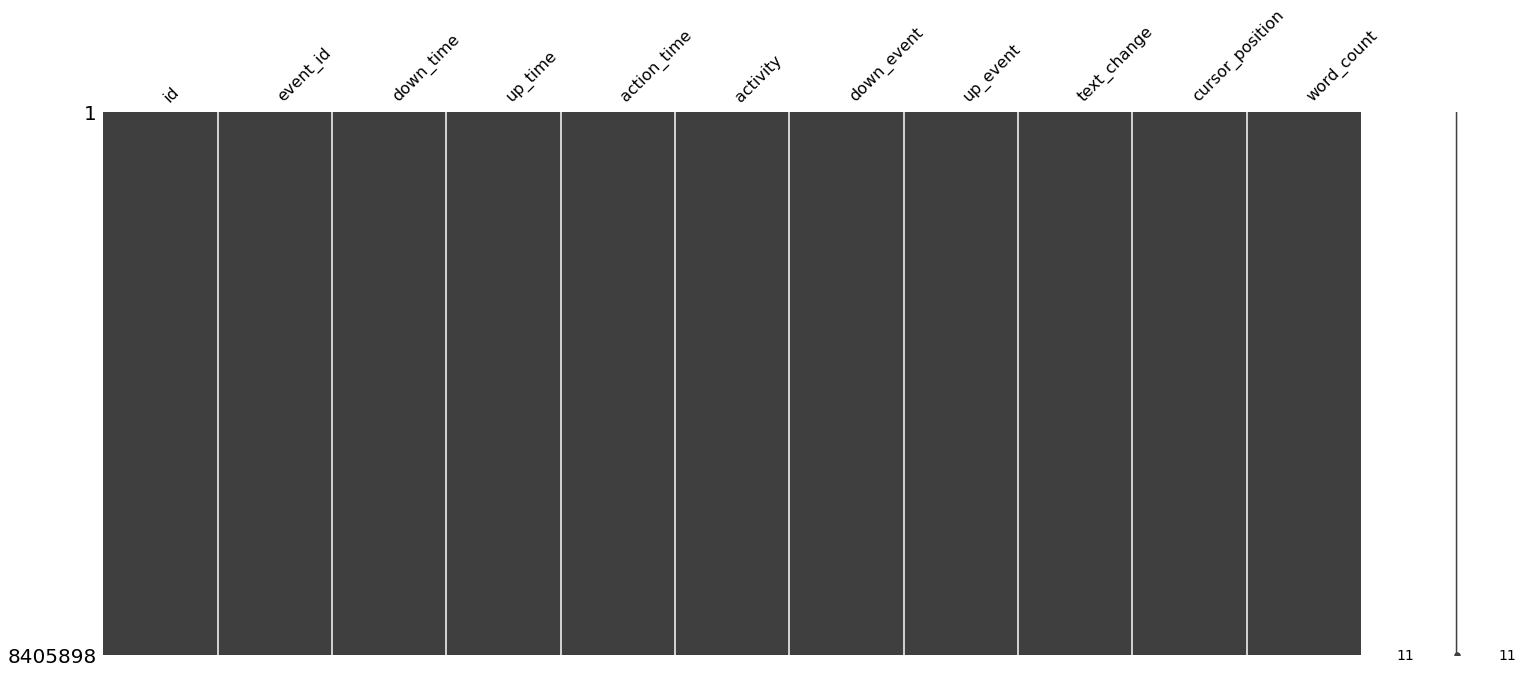

In [5]:
msno.matrix(data)

There are no missing data

In [6]:
data.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,event_id,down_time,up_time,action_time,cursor_position,word_count
count,8405898.00000,8405898.00000,8405898.00000,8405898.00000,8405898.00000,8405898.00000
mean,2067.64933,793560.28958,793658.37456,98.08498,1222.96445,231.46875
std,1588.28380,514945.05723,514942.76649,253.39846,948.52423,175.90884
min,1.00000,106.00000,252.00000,0.00000,0.00000,0.00000
25%,852.00000,373184.25000,373282.00000,66.00000,499.00000,96.00000
50%,1726.00000,720886.00000,720980.00000,93.00000,1043.00000,200.00000
75%,2926.00000,1163042.00000,1163141.00000,122.00000,1706.00000,327.00000
max,12876.00000,8313630.00000,8313707.00000,447470.00000,7802.00000,1326.00000


There are no strange numbers or number that don't make sense (eg: negative times)

Each instance of id is its own text, in order to analyze general numbes for each text it will be necessary to aggregate them

In [7]:
n_texts= data['id'].nunique()
n_texts

2471

In [8]:
features=['sum','min','max','count','std','var']
agg_columns=['down_time','up_time','action_time','cursor_position','word_count']
data_agg=data.groupby('id')[agg_columns].aggregate(features)
data_agg.columns = ['{}_{}'.format(col[0], col[1]) for col in data_agg.columns]

In [9]:
nom_columns=['activity','down_event','up_event']
activities_count= data.groupby(['id','activity'])['activity'].aggregate('count')

In [10]:
inputs_count=data[data['activity']=='Input'].groupby(['id','down_event'],as_index=False).down_event.aggregate({'count':'count'})
#The up_event only differs from down_'vent in inputs 7 times, wehre the down_event is a letter and he up_event is Ä±, i've chosen to
# not assume they are always the same and accept this noise in the data
inputs_count

,id,down_event,count
0,001519c8,',3
1,001519c8,",",12
2,001519c8,.,21
3,001519c8,;,1
4,001519c8,Enter,4
...,...,...,...
21187,fff05981,;,1
21188,fff05981,?,2
21189,fff05981,Enter,21
21190,fff05981,Space,411


In [24]:
#Creat columns for each punctuation counts
import string
inputs =data[data['activity']=='Input'].down_event.unique()
punctuation_lst=[punc for punc in string.punctuation if punc in inputs]
#punc_dict={key:value for key in puctuation_lst for value in inputs_count[key]}

In [12]:
inputs_count=data[data['activity']=='Input'].groupby(['id','down_event']).up_event.aggregate('count').reset_index()
#The up_event only differs from down_'vent in inputs 7 times, wehre the down_event is a letter and he up_event is Ä±, i've chosen to
#accept this npise in the data
inputs_count

,id,down_event,up_event
0,001519c8,',3
1,001519c8,",",12
2,001519c8,.,21
3,001519c8,;,1
4,001519c8,Enter,4
...,...,...,...
21187,fff05981,;,1
21188,fff05981,?,2
21189,fff05981,Enter,21
21190,fff05981,Space,411


In [93]:
pvt_inputs_count=inputs_count.pivot(columns='down_event',index='id')
pvt_inputs_count.columns = ['{}'.format(col[1]) for col in pvt_inputs_count.columns]
pvt_inputs_count=pvt_inputs_count[punctuation_lst]
pvt_inputs_count=pvt_inputs_count.fillna(0)

In [94]:
common_use_punc =['.',',','""',"'","-"]
def sep_punc_count(row):
    common_count=0
    others_count=0
    for col in pvt_inputs_count.columns:
        if col in common_use_punc:
            common_count+=row[col]
        else:
            others_count+=row[col]
    return pd.Series([common_count,others_count])

pvt_inputs_count[['common_punc_count','others_punc_count']]=pvt_inputs_count.apply(sep_punc_count,axis=1)

In [95]:
pvt_inputs_count

,!,"""",#,$,%,&,',(,),*,...,],^,_,`,{,|,},~,common_punc_count,others_punc_count
id,,,,,,,,,,,,,,,,,,,,,
001519c8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,1.0
0022f953,0.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,9.0
0042269b,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,4.0
0059420b,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,2.0
0075873a,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb8c745,0.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.0,5.0
ffbef7e5,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0
ffccd6fd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0


In [ ]:
a=data[data['down_event']!=data['up_event']]

In [ ]:
test=data[data['activity']=='Input'].groupby(['id','down_event'],as_index=False).down_event.aggregate({'count':'count'})



In [92]:
a=pvt_inputs_count.loc['0022f953']
a['common_punc_count']+a['others_punc_count']

nan

In [48]:
pvt_inputs_count.columns = ['{}'.format(col[1]) for col in pvt_inputs_count.columns]

Index(['!', '"', '#', '$', '%', '&', ''', '(', ')', '*', '+', ',', '-', '.',
       '/', ':', ';', '<', '=', '>', '?', '@', 'Enter', 'Space', '[', '\', ']',
       '^', '_', '`', 'q', 'z', '{', '|', '}', '~', '', '', '', '', '¡',
       '¿', 'Â´', 'Ä±', 'Å', 'Ë', 'â', 'ä'],
      dtype='object')

In [51]:
pvt_inputs_count['"']

id
001519c8    NaN
0022f953    6.0
0042269b    2.0
0059420b    NaN
0075873a    NaN
           ... 
ffb8c745    4.0
ffbef7e5    NaN
ffccd6fd    NaN
ffec5b38    6.0
fff05981    NaN
Name: ", Length: 2471, dtype: float64